In [1]:
import librosa
import matplotlib as mpl
import numpy as np
import random
import rosbag
import struct
import tams_pr2_guzheng
import tams_pr2_guzheng.utils as utils
import pandas as pd
import seaborn as sns

from collections import Counter

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from tams_pr2_guzheng.paths import RuckigPath
from IPython import display

mpl.style.use('seaborn-v0_8')

%load_ext autoreload
%autoreload 1
import sys
if '../utils' not in sys.path:
    sys.path.append('../utils')
import u
%aimport u

# helpers & setup

In [2]:
def scatter_cbar(*, data, x, y, hue, hue_norm= None, cmap= None, ax= None, **kwargs):
    if ax is None:
        ax = plt.gca()
    if hue_norm is None:
        hue_norm = mpl.colors.Normalize()
    if cmap is None:
        cmap = sns.color_palette('ch:', as_cmap= True)
    x = data[x] if type(x) == str else x
    y = data[y] if type(y) == str else y
    hue = data[hue] if type(hue) == str else hue
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=hue_norm)
    sns.scatterplot(
        data= data,
        x= x,
        y= y,
        hue= hue,
        hue_norm= sm.norm,
        palette= cmap if data.size > 0 else None,
        legend= False)
    cbar = ax.figure.colorbar(sm, ax = ax)
    cbar.set_label(hue.name)

In [3]:
def slice_animation(*, data, grid, slice_var, plot_x, plot_y, time_per_slice= 150):
    fig, ax = plt.subplots()
    palette = sns.color_palette("icefire", as_cmap=True)
    sm = plt.cm.ScalarMappable(
        cmap= palette,
        norm=mpl.colors.Normalize()
        )
    fig.colorbar(sm, ax = ax).set_label('distance to slice')

    slices = grid[slice_var].unique()
    slice_thickness = 3*np.ptp(slices)/len(slices)

    if len(plot_y) == 3:
        plot_y_data, plot_y_pred_mean, plot_y_pred_std = plot_y
    else:
        plot_y_data, plot_y_pred_mean = plot_y
        plot_y_pred_std = None

    def animate(i):
        ax.clear()
        ax.set_title(f'{slice_var} = {slices[i]:.4f}')
        grid_slice = grid[grid[slice_var] == slices[i]]
        if plot_y_pred_std is None:
            sns.lineplot(x=grid_slice[plot_x], y= grid_slice[plot_y_pred_mean].rename(plot_y_data), estimator= None, ax= ax)
        else:
            utils.plot_mean_std(grid_slice[plot_x], grid_slice[plot_y_pred_mean].rename(plot_y_data), grid_slice[plot_y_pred_std], ax= ax)
        ax.set_xlim(grid[plot_x].min(), grid[plot_x].max())
        eps= data[plot_y_data].values.ptp()/10
        ax.set_ylim(
            min((grid[plot_y_pred_mean].min(), data[plot_y_data].min()-eps)),
            max((grid[plot_y_pred_mean].max(), data[plot_y_data].max()+eps))
        )

        distance_to_slice = data[slice_var]-slices[i]
        selection_mask = np.abs(distance_to_slice) <= slice_thickness
        spread = np.max(np.abs(distance_to_slice[selection_mask]))
        sm.norm = mpl.colors.Normalize(-spread, spread)
        sns.scatterplot(
            data= data[selection_mask],
            x= plot_x,
            y= plot_y_data,
            hue= distance_to_slice[selection_mask].rename('distance to slice'),
            hue_norm= sm.norm,
            palette= palette if selection_mask.any() else None,
            ax= ax,
            legend= False
        )
        return ax

    anim = FuncAnimation(fig, animate, frames= len(slices), interval= time_per_slice)
    plt.close(fig)
    return display.HTML(anim.to_html5_video())

In [4]:
D= pd.read_json('../../../../data/20230823 - first active explorations/plucks_explore_fis4.json')
#D= pd.read_json('../../../../data/20230823 - first active explorations/plucks_explore_d4_2.json')
DF= D[['string','keypoint_pos_y', 'string_position', 'detected_note', 'loudness', 'unexpected_onsets', 'min_distance']].copy()
DF.describe()

,keypoint_pos_y,string_position,loudness,unexpected_onsets,min_distance
count,107.000000,107.000000,54.000000,107.000000,106.000000
mean,-0.001242,0.174707,50.705522,0.009346,0.012758
std,0.005711,0.115611,6.123427,0.096674,0.003580
min,-0.010548,0.000030,35.001026,0.000000,0.002857
25%,-0.006489,0.074836,46.262581,0.000000,0.010855
50%,-0.001137,0.168083,53.614929,0.000000,0.013135
75%,0.003871,0.274747,55.002836,0.000000,0.015686
max,0.006992,0.355480,57.452427,1.000000,0.017460


In [5]:
DF = DF[DF['min_distance'].notna()].copy()  # this should not be necessary, but for some reason it can happen? (maybe when failed record the trajectory?)
DL = DF[DF['loudness'].notna()].copy()  # all samples without onset are nan

In [6]:
# prepare actionspace and grid

string_len = DF['string_position'].max()

actionspace = RuckigPath.ActionSpace(
    string_position= np.array((0.0, string_len)),
    keypoint_pos_y= np.array((-0.007, 0.015)),
    keypoint_pos_z= np.array((-0.004,)),
    keypoint_vel_y= np.array((0.015,)),
    keypoint_vel_z= np.array((0.015,)),
)

features_norm_params = (
    np.array([actionspace.string_position[1]/2, (actionspace.keypoint_pos_y[0] + (actionspace.keypoint_pos_y[1]-actionspace.keypoint_pos_y[0])/2) ]),
    np.array([actionspace.string_position[1]/4, (actionspace.keypoint_pos_y[1] - actionspace.keypoint_pos_y[0])/4])
)

grid_size = 50
GridPoints = utils.make_grid_points(actionspace, grid_size)

# loudness

In [7]:
features = DL[['string_position', 'keypoint_pos_y']]
value = DL['loudness'] #.fillna(0.0)

gp_loudness = utils.fit_gp(
    utils.normalize(features, features_norm_params),
    value,
    normalize= True,
    alpha= 1.0,
    rbf_length= (0.3, 0.3),
    train= True
)
print(f"fit scale params: {gp_loudness.kernel_.k2.get_params()['length_scale']}")

GridPred= pd.DataFrame()
GridPred['mean'], GridPred['std'] = gp_loudness.predict(utils.normalize(GridPoints.values, features_norm_params), return_std= True)
Grid = GridPoints.merge(GridPred, left_index= True, right_index= True)

fit scale params: [1.65446618 1.34051317]


/tmp/ipykernel_21657/833884024.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


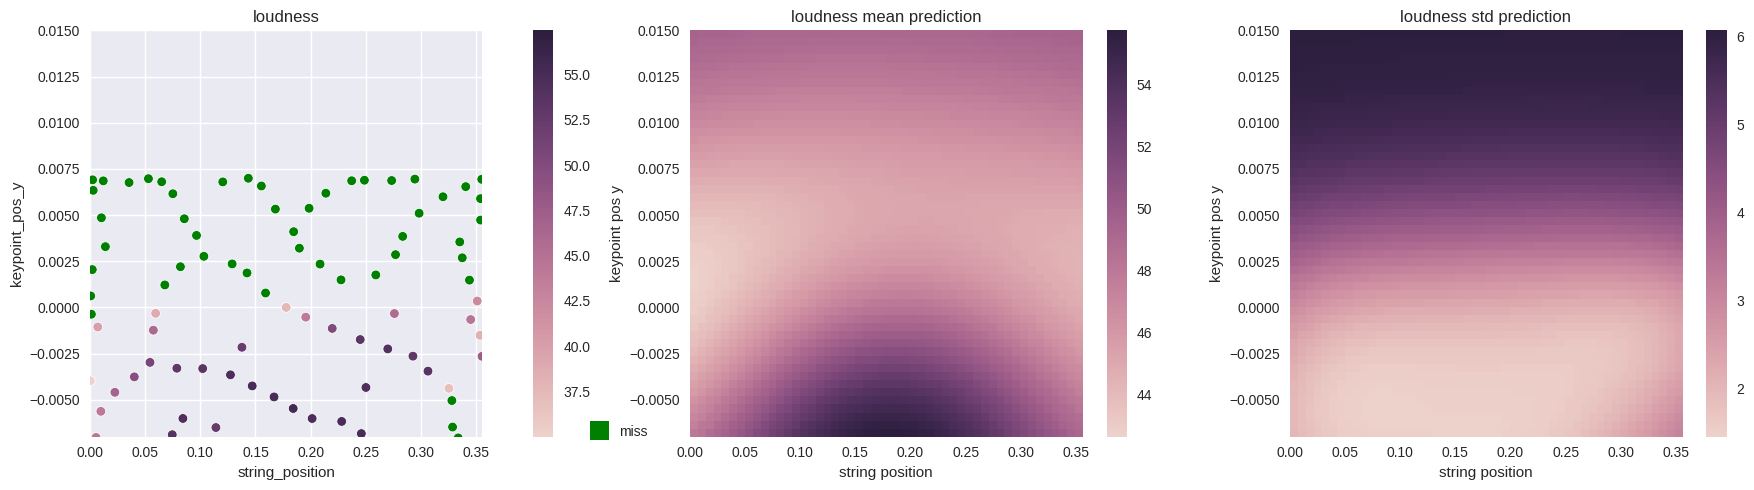

In [8]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
cmap= sns.cubehelix_palette(as_cmap=True)
utils.plot_trials(DF, DF['loudness'], ax= ax[0], actionspace= actionspace)
utils.grid_plot(GridPred['mean'], actionspace, cmap= cmap, ax= ax[1])
ax[1].set_title('loudness mean prediction')
utils.grid_plot(GridPred['std'], actionspace, cmap= cmap, ax= ax[2])
ax[2].set_title('loudness std prediction');
fig.tight_layout()

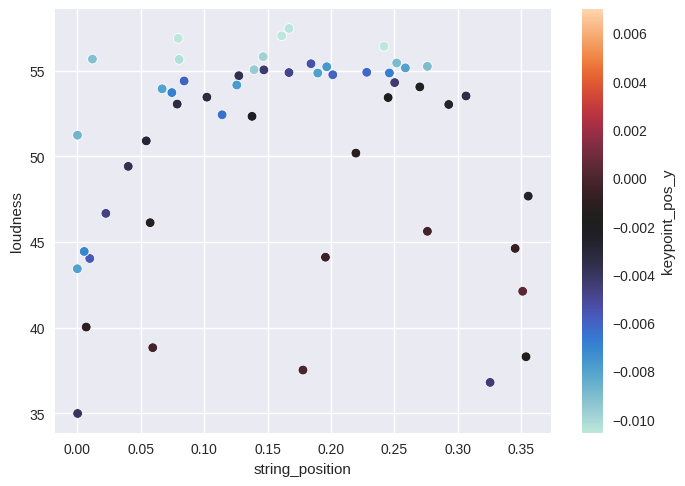

In [9]:
#plt.figure(dpi=300)
hue= 'keypoint_pos_y'
hue_spread = DF[hue].abs().max()
scatter_cbar(
    data= DF,
    x= 'string_position',
    y= 'loudness',
    hue= 'keypoint_pos_y', 
    cmap=sns.color_palette('icefire', as_cmap=True),
    norm= plt.Normalize(-hue_spread, hue_spread)
)

In [10]:
slice_animation(
    data= DL,
    grid= Grid,
    slice_var= 'keypoint_pos_y',
    plot_x= 'string_position',
    plot_y= ('loudness', 'mean', 'std')
)

In [11]:
slice_animation(
    data= DL,
    grid= Grid,
    slice_var= 'string_position',
    plot_x= 'keypoint_pos_y',
    plot_y= ('loudness', 'mean', 'std')
)

# safety

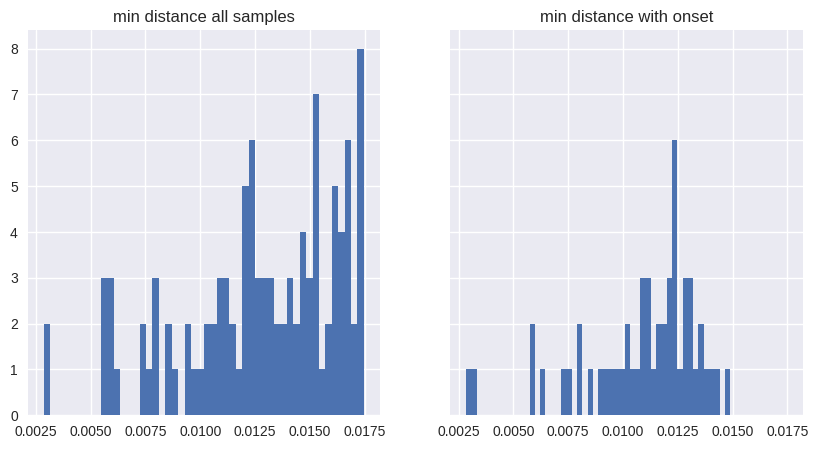

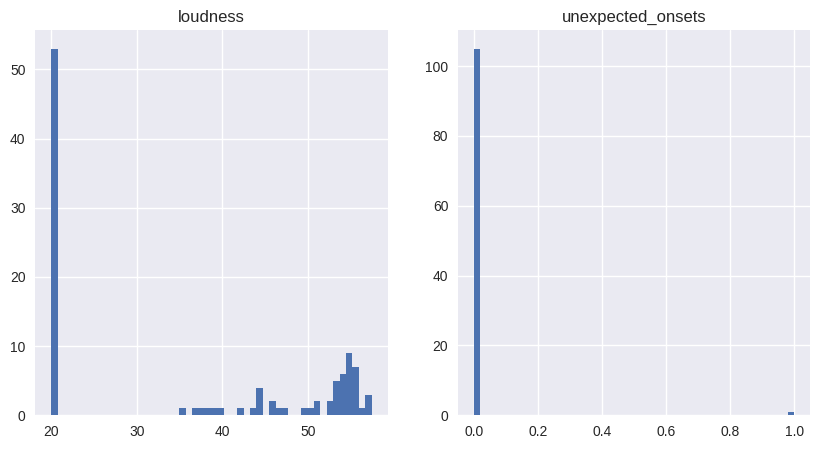

In [12]:
# overview histograms for safety inputs
fig, ax = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)
ax[0].set_title('min distance all samples')
DF['min_distance'].hist(bins= 50, ax= ax[0])
ax[1].set_title('min distance with onset')
DL['min_distance'].hist(bins= 50, ax= ax[1])
fig, ax = plt.subplots(1,2, figsize=(10,5))
DF['loudness'].fillna(20).hist(bins= 50, ax=ax[0])
ax[0].set_title('loudness')
DF['unexpected_onsets'].hist(bins= 50, ax=ax[1])
ax[1].set_title('unexpected_onsets');

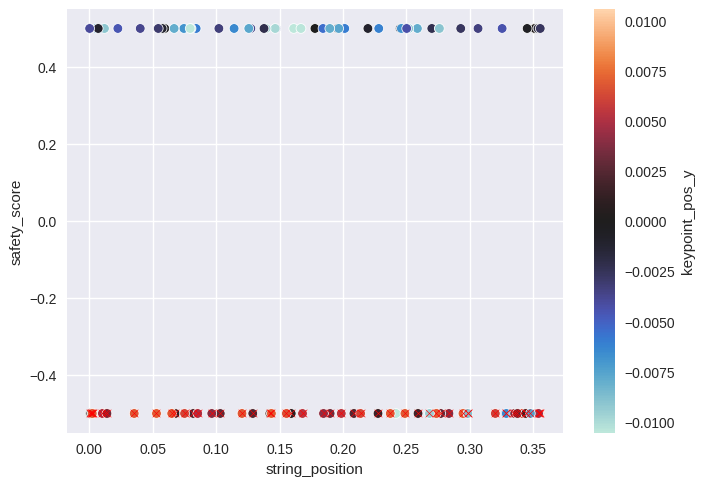

In [13]:
# compute safety and plot overview

def score_safety(df):
    # minimum distance to neighbors to consider safe
    # empirically determined accuracy of string fitting
    safe_threshold = 0.001 # m

    # distance to saturation of distance safety score
    saturation_threshold  = 0.015 # m

    # loudness cut-off
    loudness_threshold = 65.0 # dBA

    a = 1/(saturation_threshold-safe_threshold)
    b = -a*safe_threshold

    # create new pandas series with same index as df
    scores = pd.Series(np.zeros(len(df)), index= df.index, name='safety')

    #scores = (a*df['min_distance']+b)
    #scores[df['min_distance'] >= saturation_threshold] = 1.0
    scores.iloc[:] = 0.5
    scores[df['loudness'].isna()] = -0.5
    scores[df['loudness'] > loudness_threshold] = -0.5
    scores[df['unexpected_onsets'] > 0] = -0.5
    
    return scores

DF['safety_score'] = score_safety(DF)
#DF['safety_score'] = utils.score_safety(DF)

hue= 'keypoint_pos_y'
hue_spread = DF[hue].abs().max()
scatter_cbar(
    data= DF,
    x= 'string_position',
    y= 'safety_score',
    hue= 'keypoint_pos_y',
    hue_norm= plt.Normalize(-hue_spread, hue_spread),
    cmap=sns.color_palette('icefire', as_cmap=True),
)
sns.scatterplot(data= DF[DF['loudness'].isna()], x= 'string_position', y= 'safety_score', color= 'red', marker= 'x', s= 30);

In [14]:
DFFull = DF.copy()

In [15]:
DF = DFFull.copy()

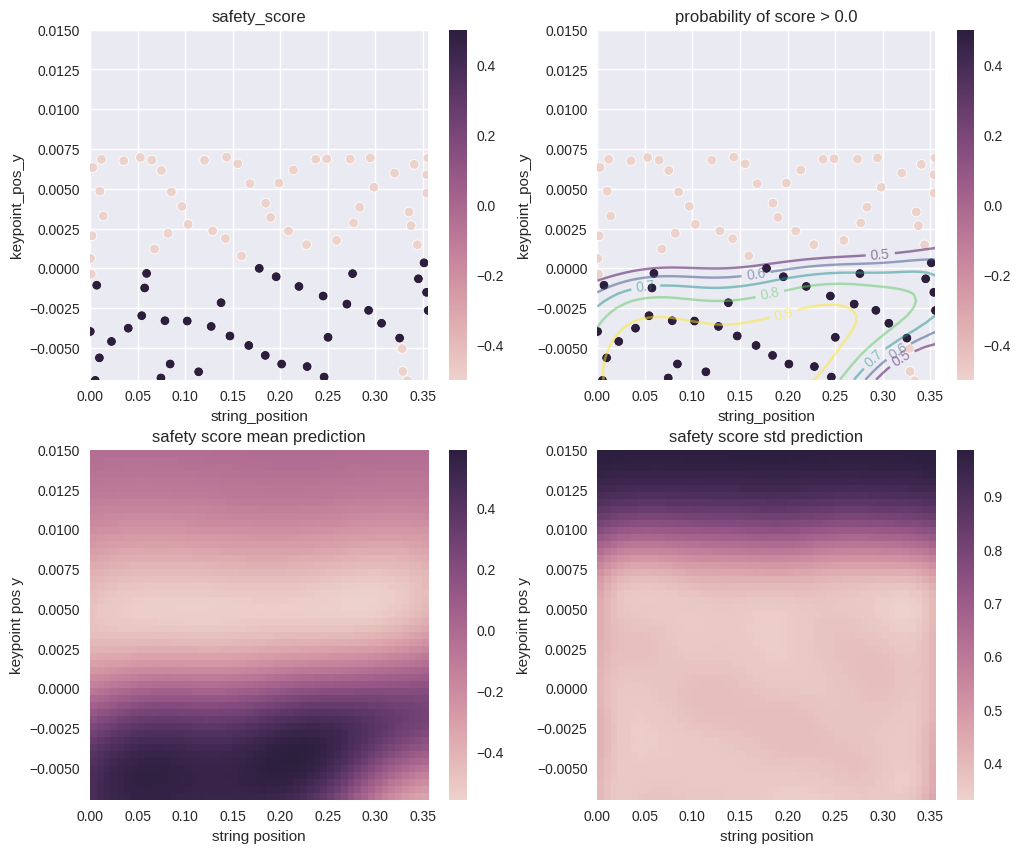

In [16]:
DF = DFFull.copy()
DF = DF.iloc[:-1]
gp_safety = utils.fit_gp(
    utils.normalize(DF[['string_position', 'keypoint_pos_y']], features_norm_params),
    DF['safety_score'].values,
    normalize= False,
    alpha= 1.0,
    rbf_length= 0.8
    )
GridPred['safety_mean'], GridPred['safety_std'] = gp_safety.predict(utils.normalize(GridPoints.values, features_norm_params), return_std= True)
Grid = GridPoints.merge(GridPred, left_index= True, right_index= True)

fig, ax = plt.subplots(2,2, figsize=(12,10))
ax = ax.ravel()
cmap= sns.cubehelix_palette(as_cmap=True)
utils.plot_trials(DF, DF['safety_score'], ax= ax[0], actionspace= actionspace)
utils.grid_plot(GridPred['safety_mean'], actionspace, cmap= cmap, ax= ax[2])
ax[2].set_title('safety score mean prediction')
utils.grid_plot(GridPred['safety_std'], actionspace, cmap= cmap, ax= ax[3])
ax[3].set_title('safety score std prediction');

Grid['p_safety'] = utils.prob_gt_zero(GridPred[['safety_mean', 'safety_std']].values.T)
cmap = sns.color_palette('viridis', as_cmap= True)
# utils.grid_plot(Grid['p_safety'], actionspace, cmap= cmap, ax= ax[1])

utils.plot_trials(DF, DF['safety_score'], ax= ax[1], actionspace= actionspace)
levels= np.linspace(0.5, .9, 5)
con = ax[1].contour(
    Grid['string_position'].values.reshape(grid_size, grid_size),
    Grid['keypoint_pos_y'].values.reshape(grid_size,grid_size),
    Grid['p_safety'].values.reshape(grid_size,grid_size),
    levels= levels,
    cmap= cmap,
    alpha= 0.5
)
ax[1].clabel(con, inline=1, fontsize=10)
ax[1].set_title('probability of score > 0.0');


In [17]:
slice_animation(slice_var= 'keypoint_pos_y', plot_x= 'string_position',
    data= DF,
    grid= Grid,
    plot_y= ('safety_score', 'safety_mean', 'safety_std')
)

In [18]:
slice_animation(slice_var= 'string_position', plot_x= 'keypoint_pos_y',
    data= DF,
    grid= Grid,
    plot_y= ('safety_score', 'p_safety')
)